In [2]:
from datetime import date as Date, timedelta
from matplotlib.ticker import MaxNLocator, MultipleLocator
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd

import geopandas
import shapely
from geopandas import GeoDataFrame
import glob
from pathlib import Path
from dateutil.parser import parse as parse_date

import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cases_url = 'https://coronavirus.data.gov.uk/downloads/{data_type}/coronavirus-cases_latest.{data_type}'
base = str(Path('~/Downloads').expanduser())
area = 'Area name'
code = 'Area code'
date = 'Specimen date'
cases = 'Daily lab-confirmed cases'
people_tested = 'Daily number of people tested'

force_download = False

lockdown = Date(2020, 3, 23)
testing = Date(2020, 4, 30)
relax_1 = Date(2020, 5, 11)

for_date = Date.today()-timedelta(days=0)

In [4]:
def download(url, path):
    response = requests.get(url)
    assert response.status_code==200
    with path.open('wb') as target:
        target.write(response.content)

In [5]:
# download testing data
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/887894/2020-05-27_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/888286/COVID-19_-_time_series_of_testing_28_May_2020.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/888748/2020-05-29_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/888827/2020-05-31_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/889016/2020-06-01_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/889446/COVID-19_-_time_series_of_testing_2_June_2020.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/889818/2020-06-03-COVID-19-UK-testing-time-series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/890069/2020-06-04_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/890451/2020-06-05_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/890549/COVID-19_UK_testing_time_series_6_June.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/890559/2020-06-07-COVID-19-UK-testing-time-series.csv'
download(testing_url, Path(base).expanduser() / f'coronavirus-testing_{Date.today()}.csv')

In [6]:
# download cases data
for suffix in 'csv', 'json':
    path = Path(base).expanduser() / f'coronavirus-cases_{Date.today()}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

In [7]:
brighton = 'E06000043'
west_sussex = 'E10000032'
east_sussex = 'E10000011'
areas = [brighton, west_sussex, east_sussex]

hammersmith = 'E09000013'
kensington = 'E09000020'
ealing = 'E09000009'
hounslow = 'E09000018'
richmond = 'E09000027'
wandsworth = 'E09000032'
brent = 'E09000005'

wirral = 'E08000015'
cheshire = 'E06000050'
liverpool = 'E08000012'
sefton = 'E08000014'
knowsley = 'E08000011'
st_helens = 'E08000013'

bristol = 'E06000023'
south_gloucestershire = 'E06000025'
bath = 'E06000022'
north_somerset = 'E06000024'

hampshire = 'E10000014'
areas = [hampshire]

bedford = 'E06000055'
central_bedfordshire = 'E06000056'
luton = 'E06000032'
hertfordshire = 'E10000015'

areas = [bedford, central_bedfordshire]

northampton = 'E10000021'
milton_keynes =  'E06000042'
bedford = 'E06000055'

wokingham = 'E06000041'
reading = 'E06000038'
west_berks = 'E06000037'
bracknell = 'E06000036'
oxfordshire = 'E10000025'

southwark = 'E09000028'
lambeth = 'E09000022'
wandsworth = 'E09000032'
westminster = 'E09000033'
cambden = 'E09000007'
islington = 'E09000019'
hackney = 'E09000012'
tower_hamlets = 'E09000030'
lewisham = 'E09000023'
city_of_london = 'E09000001'
kingston='E09000021'
surrey='E10000030'
newham = 'E09000025'

bromley = 'E09000006'
croydon = 'E09000008'



In [8]:
def testing_data_for_date(dt):
    testing_df = pd.read_csv(Path(base).expanduser() / f'coronavirus-testing_{dt}.csv',
                             index_col='Date of activity', parse_dates=True, dayfirst=True, na_values='Unavailable')
    testing_df = testing_df[(testing_df.Nation=='England') & (testing_df.Pillar=='Pillar 1')]
    testing_df.index = testing_df.index.strftime('%Y-%m-%d')
    return testing_df

In [9]:
def data_for_date(dt, areas):
    df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{dt}.csv')
    by_area = df[df['Area type'].str.startswith('Upper') & df['Area code'].isin(areas)]
    data = by_area[[date, area, cases]].pivot_table(values=cases, index=[date], columns=area).fillna(0)
    labels = pd.date_range(start=data.index.min(), end=data.index.max())
    return data.reindex([str(date.date()) for date in labels], fill_value=0)

In [10]:
def plot_diff(ax, for_date, data,previous_date, previous_data, areas):
    diff = data.sub(previous_data, fill_value=0)
    diff.plot(
        ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis',
        title=f'Change between reports on {previous_date} and {for_date}', legend=False
    )
    fix_x_dates(ax)
#     ax.yaxis.set_minor_locator(MultipleLocator(base=1.0))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.grid(True)
    ax.axhline(y=0, color='k')

def fix_x_dates(ax):
    labels = ax.xaxis.get_ticklabels()
    for i, label in enumerate(reversed(labels)):
        if i%4:
            label.set_text('')
    ax.axes.set_axisbelow(True)
    ax.xaxis.set_ticklabels(labels)
    
def plot_stacked_bars(ax, data, testing_data, uncertain_days):
    data.plot(ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis', legend=False)
    ax.set_ylabel(cases)  
    
    mean = data.sum(axis=1).rolling(7).mean()
    mean[-uncertain_days:] = np.NaN
    mean.plot(ax=ax, color='k', label='7 day average', rot=-90)

    testing_ax = ax.twinx()
    series = testing_data[people_tested]
    testing_ax.plot(series.index, series, color='b', linestyle='none', marker='o')
    average_testing = series.rolling(7).mean()
    testing_ax.plot(average_testing.index, average_testing, color='b', linestyle=':')
    testing_ax.set_ylabel('People tested - Pillar 1 in England (7 day average)')
    
    fix_x_dates(ax)
    ax.yaxis.grid(True)
    
    ax.axvline(x=data.index.get_loc(str(lockdown)), color='r', linestyle='-', label='Lockdown')
    ax.axvline(x=data.index.get_loc(str(lockdown+timedelta(days=21))), color='r', linestyle='--', label='Lockdown + 3 weeks')
    ax.axvline(x=data.index.get_loc(str(relax_1)), color='orange', linestyle='-', label='Relaxed Lockdown')

    latest_average = mean.iloc[-uncertain_days-1]
    ax.axhline(y=latest_average, color='grey', linestyle=':', label=f'Latest average: {latest_average:.1f}')

    ax.legend(loc='upper left')  
    
def plot(for_date, areas, uncertain_days, diff_days=1):
    previous_date = for_date-timedelta(days=diff_days)
    
    data = data_for_date(for_date, areas)
    previous_data = data_for_date(previous_date, areas)
    
    labels = [str(date.date()) for date in 
              pd.date_range(start=min(previous_data.index.min(), data.index.min()),
                            end=max(previous_data.index.max(), data.index.max()))]
    data = data.reindex(labels, fill_value=0)
    previous_data = previous_data.reindex(labels, fill_value=0)
    testing_data = testing_data_for_date(for_date).reindex(labels)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [12, 2]})
    fig.set_facecolor('white')
    fig.subplots_adjust(hspace=0.5)
    
    plot_diff(axes[1], for_date, data, previous_date, previous_data, areas)
    plot_stacked_bars(axes[0], data, testing_data, uncertain_days)
    plt.show()

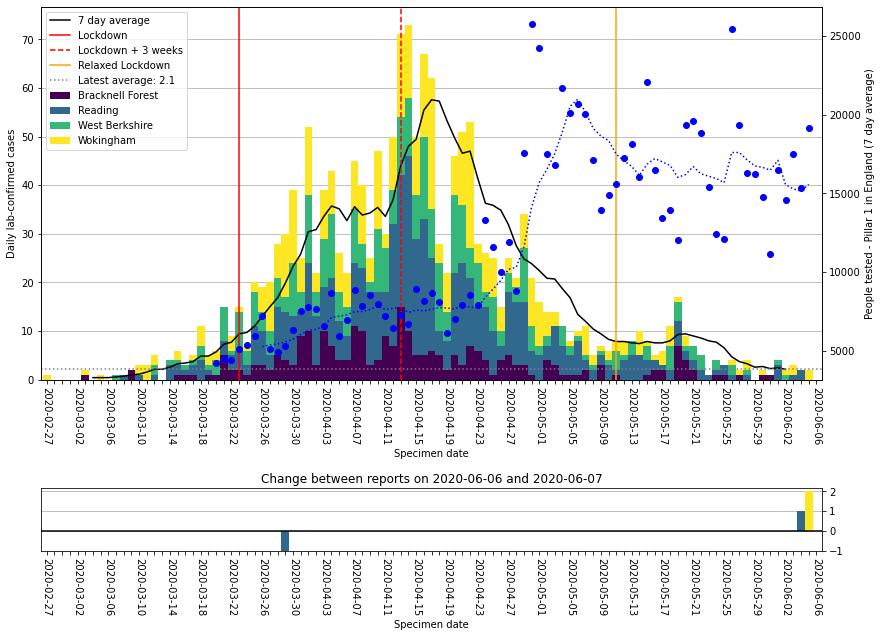

In [11]:
plot(for_date, areas = [wokingham, reading, west_berks, bracknell], uncertain_days=4)

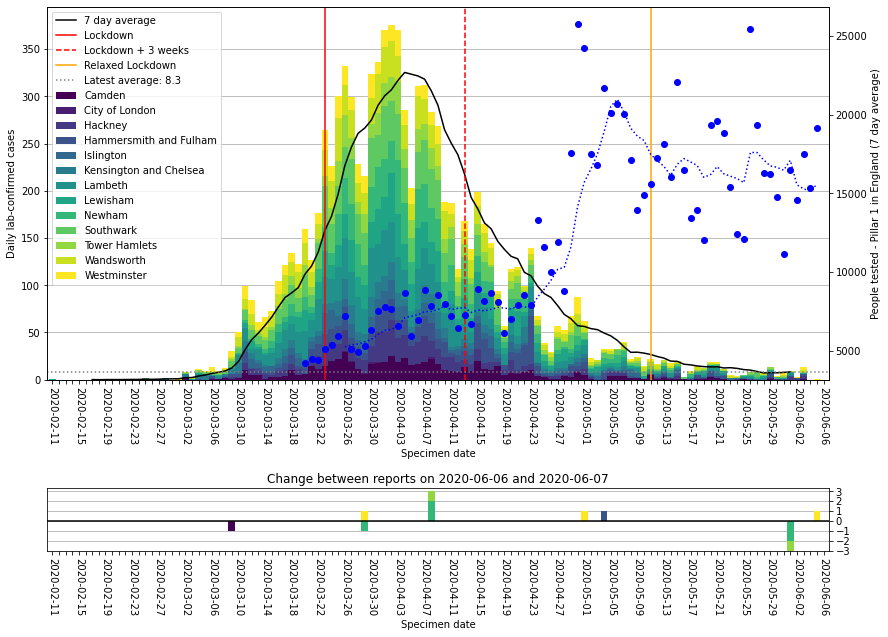

In [12]:
plot(for_date, 
     areas = [southwark, lambeth, wandsworth, hammersmith, kensington, 
              westminster, cambden, islington, hackney, tower_hamlets, lewisham, city_of_london, newham], 
     uncertain_days=5)

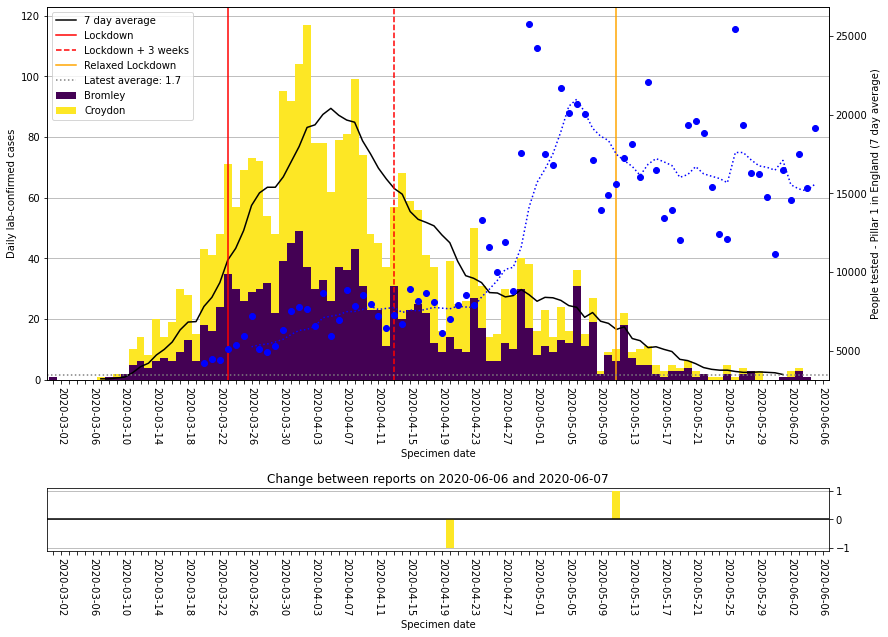

In [13]:
plot(for_date, areas = [bromley, croydon], uncertain_days=5)

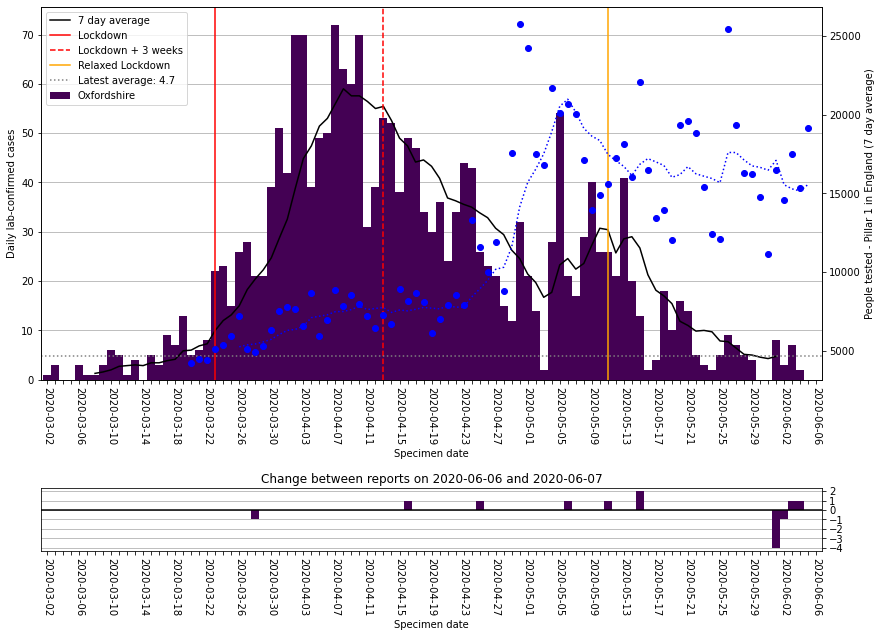

In [14]:
plot(for_date, areas = [oxfordshire], uncertain_days=5, diff_days=1)

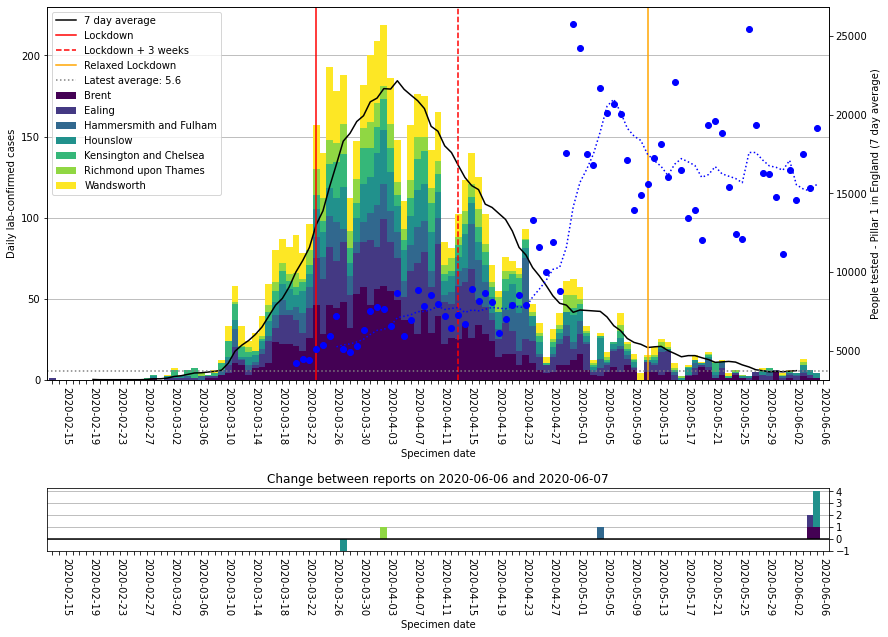

In [15]:
plot(for_date, areas = [hammersmith, kensington, ealing, hounslow, richmond, wandsworth, brent], uncertain_days=4)

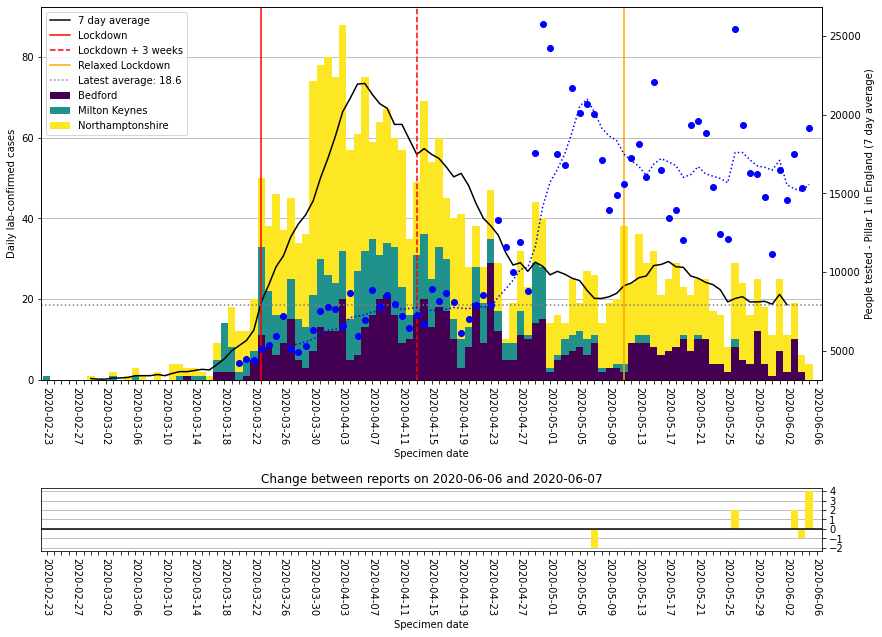

In [16]:
plot(for_date, areas = [northampton, milton_keynes, bedford], uncertain_days=4)

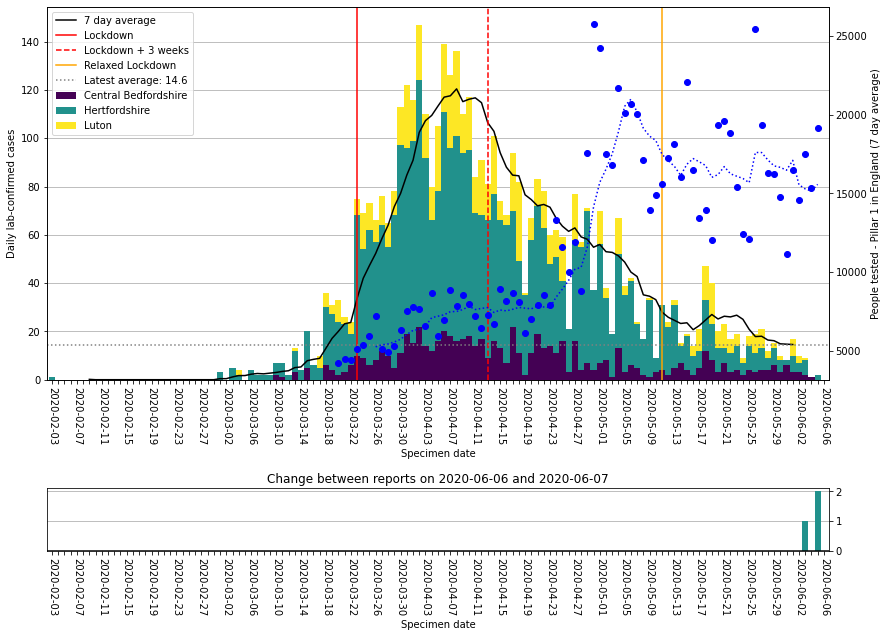

In [17]:

plot(for_date, areas = [hertfordshire, luton, central_bedfordshire], uncertain_days=5)

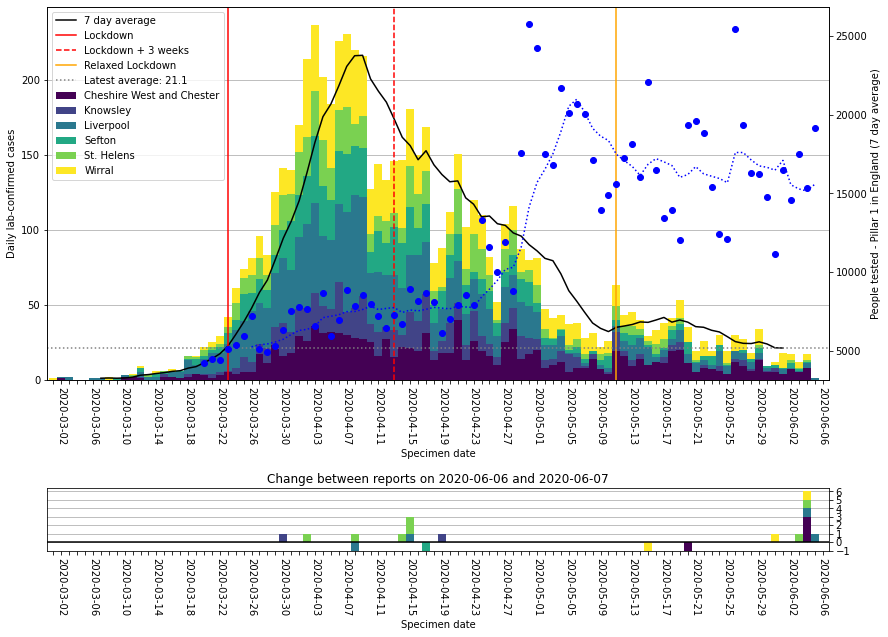

In [18]:
plot(for_date, areas = [wirral, cheshire, liverpool, sefton, knowsley, st_helens], uncertain_days=5)

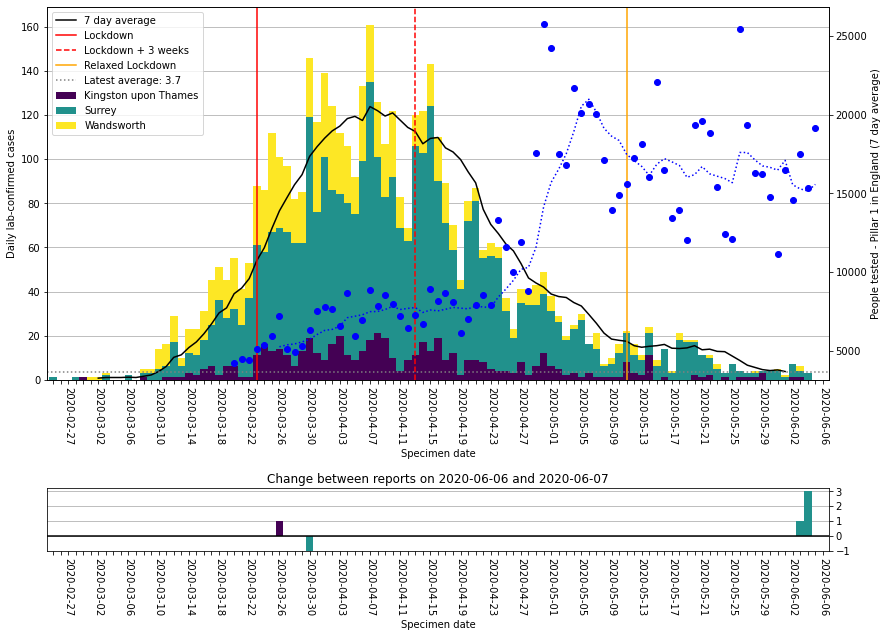

In [19]:
plot(for_date, areas = [kingston, wandsworth, surrey], uncertain_days=5)

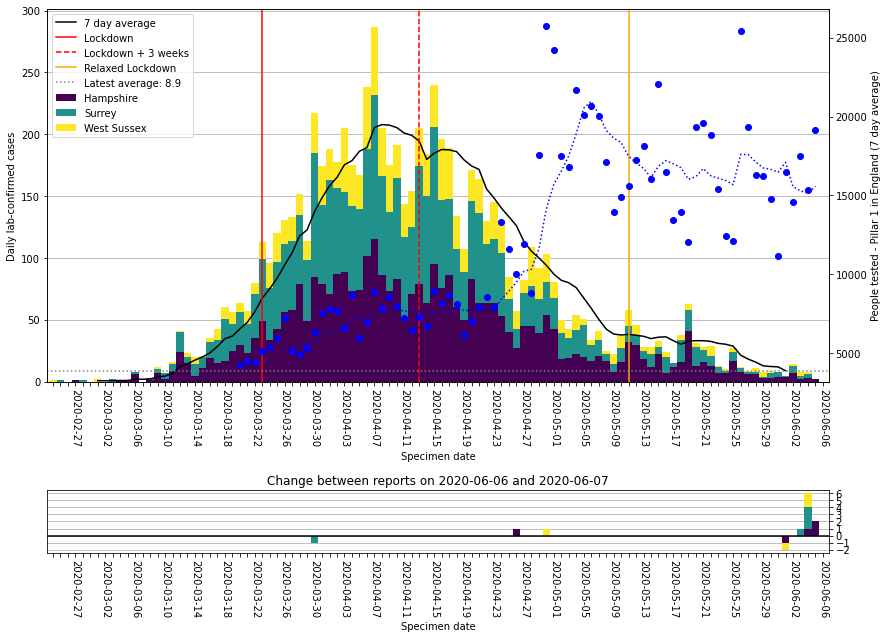

In [20]:
plot(for_date, areas = [surrey, hampshire, west_sussex], uncertain_days=5)

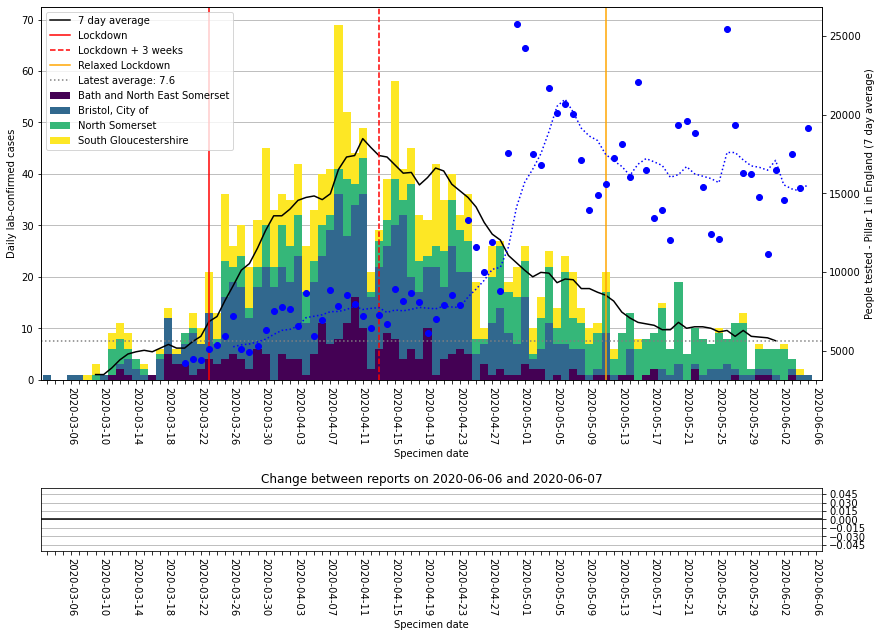

In [21]:
plot(for_date, areas = [bristol, south_gloucestershire, bath, north_somerset], uncertain_days=5)

In [22]:
recent_days = 7
earliest_date = str(for_date-timedelta(days=recent_days))
df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{for_date}.csv', parse_dates=[date])
utla_data = df[df['Area type'].str.startswith('Upper')][[area, code, date, cases]]
recent = utla_data[utla_data[date]>earliest_date]
recent.groupby(area).sum().sort_values(cases, ascending=False)[:10]

Daily lab-confirmed cases
Area name                                  
Kent                                  131.0
Lancashire                             59.0
Doncaster                              52.0
Somerset                               51.0
Northamptonshire                       44.0
Manchester                             36.0
Tameside                               35.0
Warwickshire                           32.0
Cambridgeshire                         32.0
Stoke-on-Trent                         31.0

In [23]:
df = pd.read_csv(Path(base) / f'coronavirus-cases_{for_date}.csv')
latest_ltla_data = df[(df['Specimen date'] == df['Specimen date'].max()) & (df['Area type']=='Lower tier local authority')] 

In [24]:
geoms = geopandas.read_file(str(Path(base)/'ltlas_v1.geojson')).to_crs("EPSG:3857")

In [25]:
population = pd.DataFrame({'population': json.load((Path(base)/'population.json').open())})
population.index.name = code

In [26]:
recent_days = 7
earliest_date = str(for_date-timedelta(days=recent_days))
df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{for_date}.csv', parse_dates=[date])
la_data = df[(df['Area type']=='Lower tier local authority')][[area, code, date, cases]]
recent_cases = la_data[la_data[date]>=earliest_date].groupby(code).agg({cases: 'sum', date: 'max'})
recent_pct = pd.merge(recent_cases, population, how='outer', on=code)
recent_pct['recent_days'] = recent_days
recent_pct['% of population'] = 100 * recent_pct['Daily lab-confirmed cases']/ recent_pct['population']

In [27]:
phe_recent_geo = pd.merge(geoms, recent_pct, how='outer', left_on='lad19cd', right_on='Area code')
phe_recent_title = (
    'PHE lab-confirmed cases summed over last ' 
    f"{int(phe_recent_geo['recent_days'].iloc[0])} days to {phe_recent_geo[date].max():%d %b %Y}"
)

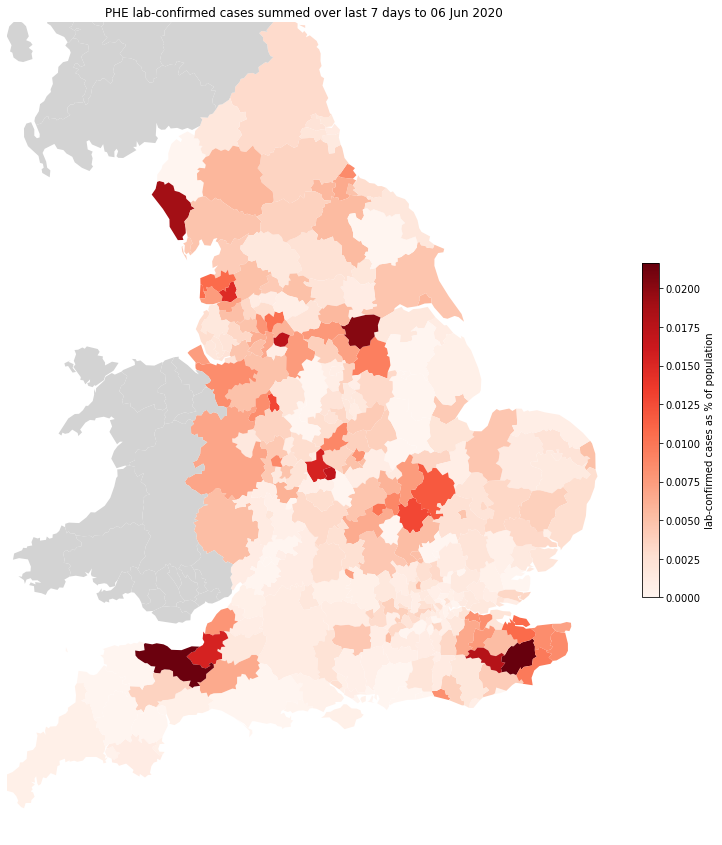

In [28]:
ax = phe_recent_geo.plot(
    column='% of population',
    k=10, figsize=(15, 15), 
    cmap='Reds', 
    legend=True, 
    legend_kwds={'fraction': 0.02, 'anchor': (0, 0), 'label': 'lab-confirmed cases as % of population'},
    missing_kwds={'color': 'lightgrey'},
)
ax.set_axis_off()
ax.set_ylim(6400000, 7500000)
ax.set_xlim(-600000,  200000)
_ = ax.set_title(phe_recent_title)

In [29]:
def convert_df(df, geom_col):
    geoms = df[geom_col]
    df[geom_col] = geoms = geoms.apply(lambda x: shapely.wkb.loads(str(x), hex=True))
    crs = "epsg:{}".format(shapely.geos.lgeos.GEOSGetSRID(geoms.iat[0]._geom))
    return GeoDataFrame(df, crs=crs, geometry=geom_col)

In [30]:
zoe_path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_final_map_*.pickle'), reverse=True)[0]
zoe_date = parse_date(str(zoe_path).rsplit('_')[-2]).date()
zoe_df = convert_df(pd.read_pickle(zoe_path), 'the_geom_webmercator')

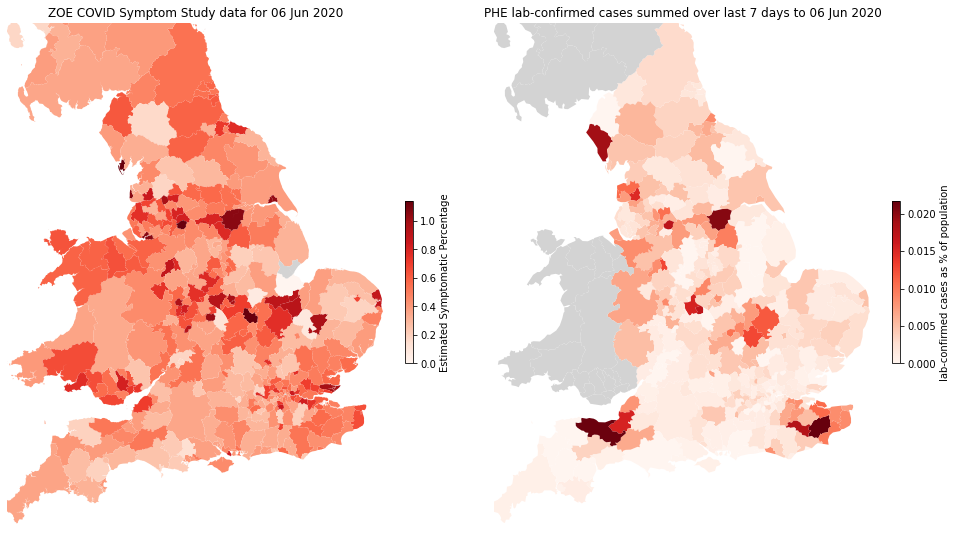

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

def show_area(ax):
    ax.set_axis_off()
    ax.set_ylim(6400000, 7500000)
    ax.set_xlim(-600000,  200000)

def plot(df, ax, column, title, label):
    df.plot(ax=ax,
        column=column, 
        k=10, 
        cmap='Reds', 
        legend=True, 
        legend_kwds={'fraction': 0.02, 'anchor': (0, 0), 'label': label},
        missing_kwds={'color': 'lightgrey'},
    )
    show_area(ax)
    ax.set_title(title)

plot(zoe_df, axes[0], 
     column='percentage', 
     title=f'ZOE COVID Symptom Study data for {zoe_date:%d %b %Y}',
     label='Estimated Symptomatic Percentage')

plot(phe_recent_geo, axes[1], 
     column='% of population', 
     title=phe_recent_title,
     label='lab-confirmed cases as % of population')

fig.set_facecolor('white')
# fig.subplots_adjust(hspace=0.5)
plt.show()    

In [39]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer, Reds
from bokeh.plotting import figure
from bokeh.io import output_notebook, output_file
from bokeh.resources import INLINE
from bokeh.transform import linear_cmap
output_notebook(resources=INLINE)

Loading BokehJS ...

In [41]:
data = phe_recent_geo[['geometry', 'lad19nm', cases, 'population', '% of population']].dropna()
geosource = GeoJSONDataSource(geojson=data.to_json())
max_pct = phe_recent_geo['% of population'].max()

p = figure(title=phe_recent_title,
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
           match_aspect=True)

areas = p.patches(
    'xs','ys', source = geosource,
    fill_color=linear_cmap('% of population', tuple(reversed(Reds[256])), 0, max_pct),
    line_color = 'gray', 
    line_width = 0, 
    fill_alpha = 1
)

p.add_tools(HoverTool(
    renderers = [areas],
    tooltips = [
        ('Name','@lad19nm'),
        ('Cases', '@{Daily lab-confirmed cases}{1}'),
        ('Population', '@{population}{1}'),
        ('Percentage','@{% of population}{1.111}%'),
    ]
))
output_file("phe.html", title=phe_recent_title)
show(p)

In [42]:
lad16cd = geopandas.read_file(str(
    Path(base) / 
    'Local_Authority_Districts__December_2016__Boundaries_UK-shp' / 
    'Local_Authority_Districts__December_2016__Boundaries_UK.shp'
))

In [43]:
zoe_new_lad16 = pd.merge(lad16cd, zoe_df[['lad16cd', 'lad16nm', 'percentage', 'percentage_string']], how='left')
geosource = GeoJSONDataSource(geojson = zoe_new_lad16.to_json())

In [44]:
zoe_title = f'ZOE COVID Symptom Study data for {zoe_date:%d %b %Y}'
p = figure(title = zoe_title, 
           plot_height = 600 ,
           plot_width = 600, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
          match_aspect=True)

areas = p.patches('xs','ys', source = geosource,
                  fill_color=linear_cmap('percentage', tuple(reversed(Reds[256])), 0, zoe_new_lad16['percentage'].max()),
                   line_color = 'gray', 
                   line_width = 0, 
                   fill_alpha = 1)

p.add_tools(HoverTool(renderers = [areas],
                      tooltips = [('Name','@lad16nm'),
                                ('Percentage','@percentage_string')]))
output_file("zoe.html", title=zoe_title)
show(p)